In [8]:
import os
import pandas as pd
import numpy as np

from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import seaborn as sns
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

In [2]:
genomic = './sars_cov2_spike_aligned/sars_cov2_spike_aligned.fasta'
report = './sars_cov2_spike.csv'

In [3]:
%%time
sequences = {}
for seq_record in SeqIO.parse(genomic, 'fasta'):
    if len(seq_record.seq) == 3822:
        sequences[seq_record.id] = seq_record.seq
len(sequences)

Wall time: 7.13 s


110604

In [4]:
%%time
df = pd.read_csv(report)
df = df[df.Accession.isin(sequences.keys())]
df = df.sort_values(by='Accession')
df.head()

Wall time: 406 ms


,Accession,ReleaseDate,PangoClass,Location,Length,Gene,Protein,Begin,End,CDS_Length
1,MW422255.1,2020-12-30,alpha,"USA: San Diego, California",29763,S,surface glycoprotein,21500,25312,3813
2,MW422256.1,2020-12-30,alpha,USA,29817,S,surface glycoprotein,21524,25336,3813
3,MW430966.1,2021-01-04,alpha,USA: California,29835,S,surface glycoprotein,21523,25335,3813
4,MW430974.1,2021-01-04,alpha,USA: Florida,29861,S,surface glycoprotein,21551,25363,3813
5,MW440433.1,2021-01-05,alpha,"USA: New York, Saratoga County",29792,S,surface glycoprotein,21514,25326,3813


In [5]:
accession_list = df.Accession.tolist()
len_acc = len(accession_list)
len_acc

110604

In [6]:
stat = np.zeros((len_acc,5,3822))
for i in tqdm(range(len_acc)):
    acc = accession_list[i]
    seq = sequences[acc]
    for j in range(3822):
        if seq[j] == 'A': 
            try: stat[i,0,j] = stat[i-1,0,j]+1
            except: stat[i,0,j] = 1
        elif seq[j] == 'T': 
            try: stat[i,1,j] = stat[i-1,1,j]+1
            except: stat[i,1,j] = 1
        elif seq[j] == 'C': 
            try: stat[i,2,j] = stat[i-1,2,j]+1
            except: stat[i,2,j] = 1
        elif seq[j] == 'G': 
            try: stat[i,3,j] = stat[i-1,3,j]+1
            except: stat[i,3,j] = 1
        elif seq[j] in ['-','n','N']: 
            try: stat[i,4,j] = stat[i-1,4,j]+1
            except: stat[i,4,j] = 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 110604/110604 [13:31<00:00, 136.29it/s]


<IPython.core.display.Javascript object>


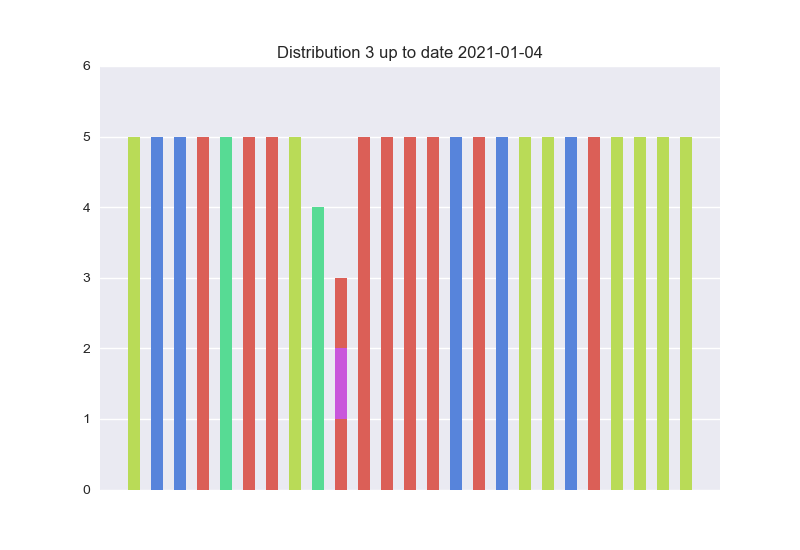

In [11]:
fig, ax = plt.subplots()
ax.set_ylim(0,6)
palette = list((sns.color_palette("hls",5).as_hex()))
plt.style.use("seaborn")

x = [str(n) for n in range(25)]
width = 0.5

def animate(k):
    sums = np.sum(stat[k],axis=0)
    yA, yT, yC, yG, yn = stat[k,0], stat[k,1], stat[k,2], stat[k,3], stat[k,4]
#     yA, yT, yC, yG, yn = yA/sums, yT/sums, yC/sums, yG/sums, yn/sums
    ax.bar(x, yA[3100:3125], label='A', width=width, color=palette[0])
    ax.bar(x, yT[3100:3125], label='T', width=width, color=palette[1], bottom=yA[3100:3125])
    ax.bar(x, yC[3100:3125], label='C', width=width, color=palette[2], bottom=yA[3100:3125]+yT[3100:3125])
    ax.bar(x, yG[3100:3125], label='G', width=width, color=palette[3], bottom=yA[3100:3125]+yT[3100:3125]+yC[3100:3125])
    ax.bar(x, yn[3100:3125], label='-', width=width, color=palette[4], bottom=yA[3100:3125]+yT[3100:3125]+yC[3100:3125]+yG[3100:3125])
    title = 'Distribution {}'.format(k+1) + ' up to date {}'.format(df[df.Accession==accession_list[k]].ReleaseDate.item())
    ax.set_title(title)
#     ax.legend(bbox_to_anchor=(1.04,0.5),loc='center left')
    ax.get_xaxis().set_visible(False)

anim = FuncAnimation(fig, animate, frames=5, interval=1, repeat=True)

In [12]:
# !brew install imagemagick
anim.save('./test.gif', writer='Pillow', fps=60)

MovieWriter Pillow unavailable; using Pillow instead.


In [186]:
seq1, seq2 = None, None
for acc in accession_list[:5]:
    seq2 = sequences[acc][3100:3125]
    if seq2 != seq1:
        print('No')
    seq1 = seq2

TGGACAATNNAAAAGAGTTGATTTT
No
TGGACAATCNAAAAGAGTTGATTTT
No
TGGACAATCAAAAAGAGTTGATTTT
No
TGGACAATCAAAAAGAGTTGATTTT
TGGACAATCAAAAAGAGTTGATTTT


In [172]:
sequences['MW422255.1'][3100:3125] == sequences['MW422256.1'][3100:3125]

False